# 1. Libraries

In [1]:
#Libraries
import os, shutil     #  file management
import pandas as pd   #  dataframe management
import numpy as np    #  data manipulation
import urllib.request #  download files
import zipfile        #  unzip files
#import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

import gensim
import gensim.downloader as gloader

from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score, classification_report

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.utils import to_categorical, set_random_seed
from keras.models import Sequential
from keras.layers import Embedding, Dense, Input, TimeDistributed, LSTM, Bidirectional, Dropout, GRU
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

np.random.seed = 17

ModuleNotFoundError: No module named 'gensim'

# 2. Dataset creation

In [ ]:
dataset_name = "dependency_treebank"

Block of code with the aim, if necessary, to clean the work directory.

---



In [ ]:
folder = os.getcwd()

print("Current work directory: " + str(folder))

dataset_folder = os.path.join(os.getcwd(), "Datasets")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

for filename in os.listdir(dataset_folder):
    file_path = os.path.join(dataset_folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

print("Cleaned")

Current work directory: /content
Cleaned


Dataset download and extraction.

In [ ]:
dataset_folder = os.path.join(os.getcwd(), "Datasets", "Original")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

dataset_path = os.path.join(dataset_folder, "Data.zip")

print(dataset_path)

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_folder)
print("Successful extraction")

/content/Datasets/Original/Data.zip
Successful download
Successful extraction


Conversion of the filename of every single file keeping the numbering.

In [ ]:
#Converting filenames 
for i in range (1, 10):
  file_path_old = os.path.join(os.getcwd(), "Datasets", "Original", dataset_name, "wsj_000"+str(i)+".dp")
  file_path_new = os.path.join(os.getcwd(), "Datasets", "Original", dataset_name, str(i)+".dp")
  if not os.path.isfile(file_path_new):
    os.rename(file_path_old,file_path_new)
  else:
    print("The file already exists")
  
for i in range (10, 100):
  file_path_old = os.path.join(os.getcwd(), "Datasets", "Original", dataset_name, "wsj_00"+str(i)+".dp")
  file_path_new = os.path.join(os.getcwd(), "Datasets", "Original", dataset_name, str(i)+".dp")
  if not os.path.isfile(file_path_new):
    os.rename(file_path_old,file_path_new)
  else:
    print("The file already exists")

for i in range (100, 200):
  file_path_old = os.path.join(os.getcwd(), "Datasets", "Original", dataset_name, "wsj_0"+str(i)+".dp")
  file_path_new = os.path.join(os.getcwd(), "Datasets", "Original", dataset_name, str(i)+".dp")
  if not os.path.isfile(file_path_new):
    os.rename(file_path_old,file_path_new)
  else:
    print("The file already exists")

Creation of the train,val and test folders and division of all the files in the correct folder knowing that:


*   Train set: from file 1 to file 100

*   Val set:from file 101 to file 150

*   Test set:from file 151 to file 200

In [ ]:
#Creating train,test and val folder
train_folder = os.path.join(os.getcwd(),"Datasets", "Original",dataset_name,"train")

if not os.path.exists(train_folder):
    os.makedirs(train_folder)

val_folder = os.path.join(os.getcwd(),"Datasets", "Original",dataset_name,"val")

if not os.path.exists(val_folder):
    os.makedirs(val_folder)
  
test_folder = os.path.join(os.getcwd(),"Datasets", "Original",dataset_name,"test")

if not os.path.exists(test_folder):
    os.makedirs(test_folder)
  
for doc_number in range(1, 200):

  filename = str(doc_number)+".dp"
  file_path = os.path.join(os.getcwd(), "Datasets", "Original", dataset_name, filename)
  #Documents 1-100 are the train set
  if(doc_number <= 100):
    shutil.move(file_path, train_folder+"/"+filename)

  #Documents 101-150 are the validation set
  if (doc_number > 100 and doc_number <= 150):
    shutil.move(file_path, val_folder+"/"+filename) 

  #Documents 151-199 are the test set
  if (doc_number > 150):
    shutil.move(file_path, test_folder+"/"+filename) 

Since in the files every single line has an unique word with the relative tag, in order to have sentences into the dataframe, the process of extraction is associated with a process of concatenation of the words and tags composing different sentences of them.

Since inside every document there are more than one phrases, as design choice, sentences of every document are not keep together but every document is associated with one or more separate sentences.

In [ ]:
def extract(extract_text,extract_tags,debug):
  '''
  Function that extract text and tags from the file as strings and as lists
  
  extract_text: string, sequence of words that as to be extracted and be inserted in a string/list
  extract_tags: string, sequence of tags that as to be extracted and be inserted in a string/list
  debug:        bool,   if True print the resulting lists and strings
  '''
  phrase = ""
  phrase_list = []
  for word in extract_text:
    phrase += str(word)+" "
    phrase_list.append(str(word))

  phrase_POS = ""
  phrase_POS_list = []
  for tag in extract_tags:
    phrase_POS += str(tag)+" "
    phrase_POS_list.append(str(tag))

  if debug:
    print(phrase)
    print(phrase_list)
    print(phrase_POS)
    print(phrase_POS_list)

  return phrase, phrase_list, phrase_POS, phrase_POS_list

Creation of the data structure `dataframe_rows` representing every line of the dataframe.


In [ ]:
def create_dataframe(dataset_name, debug = False):
  '''
  Function that extract text and tags from the file as strings and as lists

  dataset_name: string   name of the dataset from which extract datas
  debug:        bool,    if True print the resulting lists and strings
  '''

  dataframe_rows = []
  df_complete = pd.DataFrame()
  for split in ['train', 'val', 'test']:
      folder = os.path.join(os.getcwd(), "Datasets", "Original", dataset_name, split)
      for filename in os.listdir(folder):
          file_path = os.path.join(folder, filename)
          if os.path.isfile(file_path):
              # open the file
              with open(file_path, mode='r') as text_file:
                  # read it and extract informations
                  text = text_file.read()
                  df = pd.read_csv(file_path,delim_whitespace=True,names = ['Text','Tag','Number'])
                  df_complete = df_complete.append(df)
                  file_id = filename.split(".")[0]
                  df_text, df_tag = df['Text'],df['Tag']
                  text_str, text_list, tags_str, tags_list = extract(df_text, df_tag, debug=False)
                  sentences = text_str.split()
                  tags = tags_str.split()
                  if(len(sentences)!=len(tags)):
                    print("errore")
                    print(file_id)
                  dataframe_row = {
                    "file_id": file_id,
                    "split": split,
                    "text": text_list,
                    "tag": tags_list
                  }

                  # print detailed info for the first file
                  if debug:
                      print(file_path)
                      print(filename)
                      print(file_id)
                      print(text)
                      print(tag)
                      print(split)
                      print(dataframe_row)
                      debug = False
                  dataframe_rows.append(dataframe_row)

  return dataframe_rows, df_complete

def sentence_separator(dataframe_rows):
  for dr in range(len(dataframe_rows)):

    current_sentence=""
    document_sentence_list=[]
    for word in dataframe_rows[dr]["text"]:
      if(word=='.' or word=='?' or word=='!'):
        current_sentence = current_sentence + word
        document_sentence_list.append(current_sentence)
        current_sentence=""
      else:
        current_sentence = current_sentence + word + " "


    current_sentence_tags=""
    document_sentence_tags_list=[]
    for tag in dataframe_rows[dr]["tag"]:
      if(tag=='.' or tag=='?' or tag=='!'):
        current_sentence_tags = current_sentence_tags + tag
        document_sentence_tags_list.append(current_sentence_tags)
        current_sentence_tags=""
      else:
        current_sentence_tags = current_sentence_tags + tag + " "
    
    dataframe_rows[dr]["text"] = document_sentence_list
    dataframe_rows[dr]["tag"] = document_sentence_tags_list

  return dataframe_rows

Conversion of `dataframe_rows` structure into a Pandas Dataframe object

In [ ]:
dataframe_rows, df_complete = create_dataframe(dataset_name)     # list of dataframe files
dataframe = sentence_separator(dataframe_rows)      # list of dataframe files with sentence correctly separated
df = pd.DataFrame(dataframe)
df = df[[ "file_id",
          "split",
          "text",
          "tag"]]
dataframe_path = os.path.join(folder, dataset_name + ".pkl")
df.to_pickle(dataframe_path)

At the end the dataframe with the sentences correctly separated is named `df`. Now we can divide the dataframe by using the splits, this could be useful in future computations.

In [ ]:
df_train = df[df['split'] == 'train']           # train dataframe
df_val = df[df['split'] == 'val']               # validation dataframe
df_test = df[df['split'] == 'test']             # test dataframe

## 2.1 Dataset visualization

It can be seen from the output below that for each document there are more than one associated sentences and every sentence has its own relative tag sequence.

In [ ]:
def print_sentences_tags(row):  
  file_id = df["file_id"][row]

  print(f'[Debug] Sentences for the file {file_id}:')

  document_sentence_list = df["text"][row]
  for n, s in enumerate(document_sentence_list):
    print(f'  {n+1}: {s}')

  print(f'\n[Debug] Tags for the file {file_id}:')

  document_tags_list = df["tag"][row]
  for n, t in enumerate(document_tags_list):
    print(f'  {n+1}: {t}')

print_sentences_tags(row=0)

[Debug] Sentences for the file 89:
  1: The art of change-ringing is peculiar to the English , and , like most English peculiarities , unintelligible to the rest of the world .
  2: -- Dorothy L. Sayers , `` The Nine Tailors '' ASLACTON , England -- Of all scenes that evoke rural England , this is one of the loveliest : An ancient stone church stands amid the fields , the sound of bells cascading from its tower , calling the faithful to evensong .
  3: The parishioners of St. Michael and All Angels stop to chat at the church door , as members here always have .
  4: In the tower , five men and women pull rhythmically on ropes attached to the same five bells that first sounded here in 1614 .
  5: But there is also a discordant , modern note in Aslacton , though it ca n't be heard by the church-goers enjoying the peal of bells this cool autumn evening .
  6: Like most of the other 6,000 churches in Britain with sets of bells , St. Michael once had its own `` band '' of ringers , who woul

# 3. Data preparation

This code section serves to prepare the data taken from the dataset in order to be passed to the neural network architectures. Firstly, we extract the `text` and `tag` columns from the dataset, which are composed by documents, and then collapse them in order to have a collection of sentences. This procedure has to be repeated for the Train, Validation and Test set.

## 3.1 Documents to sentences

In [ ]:
def flatten(t):
  acc = [item for sublist in t for item in sublist]
  for sublist in t:
    assert type(sublist) is list
    for item in sublist:
      assert type(item) is not list
      acc.append(item)
  return acc

# Terms in the train set
X_train = flatten(df_train['text'])
Y_train = flatten(df_train['tag'])

# Terms in the validation set
X_val = flatten(df_val['text'])
Y_val = flatten(df_val['tag'])

# Terms in the test set
X_test = flatten(df_test['text'])
Y_test = flatten(df_test['tag'])

print(f'First sentence (train): \n{X_train[0]}')
print(f'First sentence tags (train): \n{Y_train[0]}')

First sentence (train): 
The art of change-ringing is peculiar to the English , and , like most English peculiarities , unintelligible to the rest of the world .
First sentence tags (train): 
DT NN IN NN VBZ JJ TO DT NNS , CC , IN JJS JJ NNS , JJ TO DT NN IN DT NN .


Now that we have obtained the sentences, we can analyze the data to see how many tags are present in the various test splits and how them are distributed.

In [ ]:
def get_tags(Y):  
  tags = []
  for sentence in Y:
    split = sentence.split()
    for el in split:
      tags.append(el)
  return set(tags)

unique_tags_train = get_tags(Y_train)
unique_tags_val = get_tags(Y_val)
unique_tags_test = get_tags(Y_test)

print(f'Train tags: {len(unique_tags_train)}')
print(f'Validation tags: {len(unique_tags_val)}')
print(f'Test tags: {len(unique_tags_test)}')

print(f'Tags not present in validation: {unique_tags_train.difference(unique_tags_val)}')
print(f'Tags not present in test: {unique_tags_train.difference(unique_tags_test)}')

Train tags: 45
Validation tags: 44
Test tags: 40
Tags not present in validation: {'SYM'}
Tags not present in test: {'#', 'LS', 'SYM', 'FW', 'UH'}


We can see that in the test sets there several tags missing, while Train and Validation set tags got a similar number of tags. Therefore, we are maybe curious to understand how many unique words are present in each split. Note that the number of words can vary considerably if we consider `TrueCase` words instead of `LowerCase` ones.

In [ ]:
def get_word_listing(dataframe: pd.DataFrame, lowerCase=True):
  """
  Returns the set of the words in the given dataframe

  :param dataframe: split of dataframe (pd.DataFrame)
  :param lowerCase: force to consider only lower case words

  :return
    - set of unique words for the specified dataframe
  """
  word_listing = []
  text_documents = dataframe['text'].to_numpy()
  for sentence_list in text_documents:
    assert type(sentence_list) is list

    for sentence in sentence_list:
      assert type(sentence) is str

      list_of_words = sentence.split(' ')
      for term in list_of_words:
        word_listing.append(term.lower()) if lowerCase else word_listing.append(term)

  return set(word_listing)

lower_case = True

word_listing_df         = get_word_listing(df, lower_case)
word_listing_train      = get_word_listing(df_train, lower_case)
word_listing_val        = get_word_listing(df_val, lower_case)
word_listing_test       = get_word_listing(df_test, lower_case)

print(f'Unique words in the dataset: {len(word_listing_df)}')
print(f'Unique words in the training dataset: {len(word_listing_train)}')
print(f'Unique words in the validation dataset: {len(word_listing_val)}')
print(f'Unique words in the test dataset: {len(word_listing_test)}')

Unique words in the dataset: 10945
Unique words in the training dataset: 7402
Unique words in the validation dataset: 5420
Unique words in the test dataset: 3407


## 3.2 GloVe embedding
Firstly we have to choose and download a pre-trained embedding model in order to represent words in our models: we have to assign to each word a word-embedding. In this assignment we have to use GloVe as embedding model and to load it we will use the methods provided by the `Gensim` library.

In [ ]:
def load_glove(embedding_dimension: int) -> gensim.models.keyedvectors.KeyedVectors:
  """
  Loads a pre-trained GloVe embedding model via gensim library.

  We have a matrix that associate words to a vector of a user-defined dimension.
  """

  download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)

  # check the download process
  try:
    emb_model = gloader.load(download_path)
  except ValueError as e:
    print("Generic error when loading GloVe")
    print("Check embedding dimension")
    raise e

  emb_model = gloader.load(download_path)
  return emb_model

# Parameters
#embedding_dimension = 50
#embedding_dimension = 100
#embedding_dimension = 200
embedding_dimension = 300

embedding_model = load_glove(embedding_dimension)

[==================================================] 100.0% 376.1/376.1MB downloaded


### 3.2.1 OOV words

To properly use this emebeddings we have to define an embedding matrix $M$ of size $|V| \times d$, where $|V|$ is the number of unique words in the corpus (the cardinality of our vocabulary) and $d$ is the dimensionality chosen for our word embeddings ($d \in \{50, 100, 200, 300\}$).
In order to do so, we have to find a way to handle *Out-Of-Vocabulary* (OOV) terms, namely words that are not present in the GloVe model but still they are present in our dataset.  


In [ ]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - set of OOV terms
    """

    embedding_vocabulary = set(embedding_model.vocab.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return oov

print(f"Total number of terms present in the GloVe embedding model: {len(embedding_model.vocab)}")
print(f'Terms that are present both on GloVe and our dataset: {len(set(embedding_model.vocab.keys()).intersection(word_listing_df))}')
print(f'Expected OOV terms: {len(word_listing_df) - len(set(embedding_model.vocab.keys()).intersection(word_listing_df))}')

Total number of terms present in the GloVe embedding model: 400000
Terms that are present both on GloVe and our dataset: 10269
Expected OOV terms: 676


After we have defined the function that extracts the OOV terms we can proceed to extract the OOV words from each set independently, this step is really important in the next future but for now we will simply look at the percentage of OOV terms in each split in order to consider the approach to apply to build the embedding matrix.

In [ ]:
oov_terms = check_OOV_terms(embedding_model, word_listing_df)

oov_terms_train = check_OOV_terms(embedding_model, word_listing_train)  
oov1 = oov_terms_train                                                  

oov_terms_val = check_OOV_terms(embedding_model, word_listing_val)      
oov2 = oov_terms_val - oov1                                   

oov_terms_test = check_OOV_terms(embedding_model, word_listing_test)   
oov3 = oov_terms_test - oov2 - oov1                    

print("Total OOV terms: {0} ({1:.2f}%)".format(len(oov_terms), float(len(oov_terms)) / len(set(word_listing_df))))
print("Total training OOV terms: {0} ({1:.2f}%)".format(len(oov1), float(len(oov1)) / len(set(word_listing_train))))
print("Total validation OOV terms: {0} ({1:.2f}%)".format(len(oov2), float(len(oov2)) / len(set(word_listing_val))))
print("Total test OOV terms: {0} ({1:.2f}%)".format(len(oov3), float(len(oov3)) / len(set(word_listing_test))))

Total OOV terms: 676 (0.06%)
Total training OOV terms: 359 (0.05%)
Total validation OOV terms: 189 (0.03%)
Total test OOV terms: 128 (0.04%)


The procedure is pretty straightforward, we simply remove the terms that already in other sets by performing a set difference.

Now we have to perform some sanity checks on the sets produced before. In order to have a sequential process we must have an empty intersection between the OOV words of each set, in this way when we build the vocabulary we will proceed by adding at each step new words. 

In [ ]:
assert oov1.intersection(oov2, oov3) == set()
assert len(oov1) + len(oov2) + len(oov3) == len(word_listing_df) - len(set(embedding_model.vocab.keys()).intersection(word_listing_df))

## 3.3 Tokenization and embedding matrix creation

Now that we have all the ingredients to build the embedding matrix $M$, we provide a method that builds the matrix given the GloVe model and a defined vocabulary of wrods, that explicits a one-to-one mapping between each word and a number. We have decided to assign a uniformly generated random vector for OOV terms since they are a little percentage with respect to all the terms present in the dataset.

In [ ]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx,
                           vocab_size: int) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """

    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    oov_count = 0

    # For each word which is not present in the vocabulary we assign a random vector, otherwise we take the GloVe embedding
    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            oov_count += 1
            # embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
            embedding_vector = np.random.uniform(low=-0.1, high=0.1, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector
    
    print(f'\n[Debug]{oov_count} OOV words found!')
    return embedding_matrix

We have different ways to produce such vocabulary, but we prefer to use a very useful utility class from **Keras**, which is the `Tokenizer`. Moreover, it also produces a tokenized output given a list of sentences as input. It is important to notice that we produce three different matrices since we want to explicit the sequentiality of the process, namely the fact that we have followed these steps:

1. Starting vocabulary $V1$(in this assignment, *GloVe* vocabulary)
2. Compute embeddings for terms out of vocabulary $V1$ ($OOV1$) of the training split 
3. Add embeddings to the vocabulary, so to obtain vocabulary $V2=V1+OOV1$
4. Compute embeddings for terms $OOV2$ of the validation split 
5. Add embeddings to the vocabulary, so to obtain vocabulary $V3=V1+OOV1+OOV2$
6. Compute embeddings for terms $OOV3$ of the test split 
7. Add embeddings to the vocabulary, so to obtain vocabulary $V4=V1+OOV1+OOV2$

Basically after initialized a `Tokenizer` for the words (called `word_tokenizer`) and the tags (called `tag_tokenizer`), the procedure is the same for each split:
1. Fit both the `word_tokenizer` and the `tag_tokenizer` on the current split set. This point is crucial to produce the vocabulary aforementioned since the `fit_on_texts` method updates the internal vocabulary based on a list of texts. 
2. Produce the tokenized sentences for the current set by using the method `text_to_sequences()` on both the text sentences and the tags.
3. Produce the embedding matrix by passing the vocabulary produced in the first step.

Note that in the following code we do not call the fit method of the `tag_tokenizer` on each split but only on the training set, this is due to the fact that the training set already contains all the tags present in the dataset (still calling on validation and test split should does not change the things!).

In [ ]:
# Initialize a Tokenizer for the words and one for the tags
word_tokenizer = Tokenizer(lower=lower_case, filters=[])
tag_tokenizer = Tokenizer(lower=lower_case, filters=[])

# Fit the Tokenizer on the training data and then process it to obtain tokens (V2)
word_tokenizer.fit_on_texts(X_train)
#X_train_encoded = word_tokenizer.texts_to_sequences(X_train)

tag_tokenizer.fit_on_texts(Y_train)
#Y_train_encoded = tag_tokenizer.texts_to_sequences(Y_train)

# After the Tokenizer has been fitted, we proceed to build the matrix by using the vocabulary produced by the fitting process
V2_embedding_matrix = build_embedding_matrix(embedding_model=embedding_model,
                                              word_to_idx=word_tokenizer.word_index,
                                              vocab_size=len(word_tokenizer.word_index)+1,          
                                              embedding_dimension=embedding_dimension)

# Fit the Tokenizer on the validation data and then process it to obtain tokens (V3)
word_tokenizer.fit_on_texts(X_val)
#X_val_encoded = word_tokenizer.texts_to_sequences(X_val)

# tag_tokenizer.fit_on_texts(Y_val)
#Y_val_encoded = tag_tokenizer.texts_to_sequences(Y_val)

V3_embedding_matrix = build_embedding_matrix(embedding_model=embedding_model,
                                              word_to_idx=word_tokenizer.word_index,
                                              vocab_size=len(word_tokenizer.word_index)+1,          
                                              embedding_dimension=embedding_dimension)

# Fit the Tokenizer on the testing data and then process it to obtain tokens (V4)
word_tokenizer.fit_on_texts(X_test)
#X_test_encoded = word_tokenizer.texts_to_sequences(X_test)

# tag_tokenizer.fit_on_texts(Y_test)
#Y_test_encoded = tag_tokenizer.texts_to_sequences(Y_test)

V4_embedding_matrix = build_embedding_matrix(embedding_model=embedding_model,
                                              word_to_idx=word_tokenizer.word_index,
                                              vocab_size=len(word_tokenizer.word_index)+1,          
                                              embedding_dimension=embedding_dimension)

100%|██████████| 7402/7402 [00:00<00:00, 215346.14it/s]



[Debug]359 OOV words found!


100%|██████████| 9899/9899 [00:00<00:00, 215162.18it/s]



[Debug]548 OOV words found!


100%|██████████| 10945/10945 [00:00<00:00, 224646.11it/s]


[Debug]676 OOV words found!


In [ ]:
X_train_encoded = word_tokenizer.texts_to_sequences(X_train)
Y_train_encoded = tag_tokenizer.texts_to_sequences(Y_train)

X_val_encoded = word_tokenizer.texts_to_sequences(X_val)
Y_val_encoded = tag_tokenizer.texts_to_sequences(Y_val)

X_test_encoded = word_tokenizer.texts_to_sequences(X_test)
Y_test_encoded = tag_tokenizer.texts_to_sequences(Y_test)

Aftee we have built our vocabulary and the associated matrix we add a value for the padding, which by default is set to `0`, to the reserved index `0`.

In [ ]:
# Add to each Tokenizer's vocabulary a special entry for the padding      
word_tokenizer.word_index['0'] = 0     
tag_tokenizer.word_index['0'] = 0

print(f'\nV4 vocabulary size (pad value included): {V4_embedding_matrix.shape[0]}') 


V4 vocabulary size (pad value included): 10946


## 3.4 Padding

The reserved index will be used for padding, and we apply a useful tool from keras which allow us to pad sequences easily. We have to decide how much we want to pad tough. This is done by looking at the sentences length present in the dataset.

In [ ]:
length_train = [len(seq) for seq in X_train_encoded]
print("Lenght of longest sentence in the Train set: {}".format(np.max(length_train)))
print("Mean length in for sentences in the Train set: {}\n".format(np.mean(length_train)))

length_val = [len(seq) for seq in X_val_encoded]
print("Lenght of longest sentence in the Validation set: {}".format(np.max(length_val)))
print("Mean length in for sentences in the Validation set: {}\n".format(np.mean(length_val)))

length_test = [len(seq) for seq in X_test_encoded]
print("Lenght of longest sentence in the Test set: {}".format(np.max(length_test)))
print("Mean length in for sentences in the Test set: {}".format(np.mean(length_test)))

Lenght of longest sentence in the Train set: 250
Mean length in for sentences in the Train set: 24.17202654415518

Lenght of longest sentence in the Validation set: 80
Mean length in for sentences in the Validation set: 24.418950665622553

Lenght of longest sentence in the Test set: 80
Mean length in for sentences in the Test set: 24.365203761755485


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


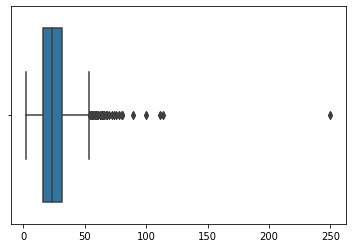

In [ ]:
length = length_train + length_val + length_test

sns.boxplot(length)

As we can see the majority of sentences have length values around 110, whereas a minority got a greater length. In order to choose a good padding length we take the length that allow us to consider approximately 98% of the phrases. 



In [ ]:
max_seq_length = int(np.quantile(length, 0.9997))

X = df['text']
Y = df['tag']

X_terms = flatten(df["text"])
X_encoded = word_tokenizer.texts_to_sequences(X_terms)

length = []
for idx, seq in enumerate(X_encoded):
  length.append(len(seq))
  
print(f'Mean length: {np.mean(length):.2f}')
print(f'Max length: {np.max(length)}')
print(f'Number of sentences with length greater than {max_seq_length}: {np.sum([s > max_seq_length for s in length])}')

Mean length: 24.29
Max length: 250
Number of sentences with length greater than 114: 2


Here we apply the padding by using the Keras tool aforementioned.

In [ ]:
#Padding "pre" or "post"
pad = "post"

# Train
X_train_padded = pad_sequences(X_train_encoded, maxlen=max_seq_length, padding=pad)
Y_train_padded = pad_sequences(Y_train_encoded, maxlen=max_seq_length, padding=pad)

# Validation
X_val_padded = pad_sequences(X_val_encoded, maxlen=max_seq_length, padding=pad) 
Y_val_padded = pad_sequences(Y_val_encoded, maxlen=max_seq_length, padding=pad)

# Test
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_seq_length, padding=pad)
Y_test_padded = pad_sequences(Y_test_encoded, maxlen=max_seq_length, padding=pad)

print(f'X_train padded: {X_train_padded.shape}, Y_train padded: {Y_train_padded.shape}')
print(f'X_val padded: {X_val_padded.shape}, Y_val padded: {Y_val_padded.shape}')
print(f'X_test padded: {X_test_padded.shape}, Y_test padded: {Y_test_padded.shape}')

X_train padded: (3918, 114), Y_train padded: (3918, 114)
X_val padded: (2554, 114), Y_val padded: (2554, 114)
X_test padded: (1276, 114), Y_test padded: (1276, 114)


## 3.5 One-Hot Encoding

Finally, the last step before feeding the values as input for the neural network is to apply an one-hot encoding to the labels of the various splits.

In [ ]:
# Train
Y_train_cat = to_categorical(Y_train_padded)
print(Y_train_cat.shape)

# We have to force the number of classes beacuse in the validation and the test there could be a smaller number
# Validation
Y_val_cat = to_categorical(Y_val_padded, num_classes=Y_train_cat.shape[2])
print(Y_val_cat.shape)

# Test
Y_test_cat = to_categorical(Y_test_padded)
print(Y_test_cat.shape)

(3918, 114, 46)
(2554, 114, 46)
(1276, 114, 42)


# 4. Model definition

Now that we have all the words encoded, padded we can start to define and train the neural network models in order to make prediction on validation and test set. Based on these predictions we will make evaluation in order to understand which model is the most appropriate for this task having these data available.

In [ ]:
num_classes = Y_train_cat.shape[2]
print(f'Number of tag classes: {num_classes}')

Number of tag classes: 46


First of all there is the need to create generic methods that will help in the prediction and training processes. Also the definition of a plot function for the training trend can be useful for a graphical view of how the network behaves during training.

In [ ]:
def train_model(model,
                x_train: np.ndarray,
                y_train: np.ndarray,
                x_val: np.ndarray,
                y_val: np.ndarray,
                training_info):
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param x_train: training data in np.ndarray format
    :param y_train: training labels in np.ndarray format
    :param x_val: validation data in np.ndarray format
    :param y_val: validation labels in np.ndarray format
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """
    print("Start training \nParameters: {}".format(training_info))
    history = model.fit(x=x_train, y=y_train,
                        validation_data=(x_val, y_val),
                        **training_info)
    print("Training completed")
    return history, model

def predict_data(model,
                 x: np.ndarray,
                 prediction_info) -> np.ndarray:
    """
    Inference routine of a given input set of examples

    :param model: Keras built and possibly trained model
    :param x: input set of examples in np.ndarray format
    :param prediction_info: dictionary storing model predict() argument information

    :return
        predictions: predicted labels in np.ndarray format
    """

    print('Starting prediction: \n{}'.format(prediction_info))
    print('Predicting on {} samples'.format(x.shape[0]))

    predictions = model.predict(x, **prediction_info)
    return predictions

def plot_accuracy_loss(hist):
    fig, axs = plt.subplots(1,2)
    fig.suptitle('Training trends')
    axs[0].plot(hist.history['accuracy'])
    axs[0].plot(hist.history['val_accuracy'])
    axs[0].set_title("model accuracy")
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='best')
    

    axs[1].plot(hist.history['loss'])
    axs[1].plot(hist.history['val_loss'])
    axs[1].set_title("model loss")
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='best')

    plt.show()

For the evaluation we need to get rid of tags representing symbols and 
punctuation, so we have to extract the correct tags that has to be involved in evaluation process. The metric chosen for the evaluation is the **macro f1**, computed token by token. Indeed, since the output of the network is one-hot encoded we had to collapse the list into an one and only one numpy array, which contains all the tokens without considering sentences.

In [ ]:
def get_punctuation_tags(dataframe):
  """
  Provides the tags that are considered punctuation.

  :param dataframe: dataframe

  :return
      - tags: list of punctuation tags
  """
  df_text_tag = pd.DataFrame(dataframe, columns= ['Text','Tag'])
  punctuation_tags = []
  tags = df_text_tag[df_text_tag['Tag'].str.match('^[\W]')== True]
  tags = tags["Tag"].unique()
  return tags

def get_evaluation_tags(dataframe, tag_tokenizer):
  """
  Provides the tags that should be used in the evaluation process

  :param dataframe: dataframe
  :param tag_tokenizer: a Tokenizer that had been already fitted on tag data 

  :return
      - (eval_tags, eval_values): list of evaluation tags and respective values
  """
  punctuation_tags = get_punctuation_tags(dataframe)

  tags_vocab = tag_tokenizer.word_index
  tags = [*tags_vocab]                                              # extract the keys of the vocab  
  eval_tags = list(set(tags).difference(set(punctuation_tags)))     # tags to be considered in the evaluation
  eval_tags.remove('0')

  eval_values = []                                                  # values of evaluation tags
  for tag in eval_tags:
    eval_values.append(tags_vocab[tag])

  print(f'[Debug] Punctuation tags: {punctuation_tags}')

  return eval_tags, eval_values

eval_tags, eval_values = get_evaluation_tags(df_complete, tag_tokenizer)

import warnings
warnings.filterwarnings("ignore")

def flatten_to_numpy(list):
  """
  Utility method that flattens a list but forces the result to be an np.ndarray
  """
  seq = list[0]
  for s in list[1:]:
    seq = np.concatenate([seq, s])
  return seq

def compute_f1_score(predictions, y, labels):
  return f1_score(flatten_to_numpy(predictions), flatten_to_numpy(y), average='macro', labels=labels)

def compute_accuracy_score(predictions, y):
  return accuracy_score(flatten_to_numpy(predictions), flatten_to_numpy(y))

def evaluate_predictions(predictions: np.ndarray,
                         y: np.ndarray,
                         eval_val):
    """
    Evaluates given model predictions on a list of metric functions

    :param predictions: model predictions in np.ndarray format
    :param y: ground-truth labels in np.ndarray format
    :param metrics: list of metric functions
    :param metric_names: list of metric names

    :return
        metric_info: dictionary containing metric values for each input metric
    """

    metrics = [
      partial(compute_accuracy_score),
      partial(compute_f1_score, labels=list(set(eval_val).intersection(set(np.unique(predictions)))))
    ]

    metric_names = [
      "accuracy",
      "macro_f1"
    ]

    print("Evaluating predictions! Total samples: ", len(y))

    metric_info = {}

    for metric, metric_name in zip(metrics, metric_names):
      metric_value = metric(predictions, y)
      metric_info[metric_name] = metric_value

    return metric_info

[Debug] Punctuation tags: [',' '.' ':' '``' "''" '-LRB-' '-RRB-' '$' '#']


Definition of some variables representing some hyperparameters for the neural network models

In [ ]:
BATCH_SIZE = 64
HIDDEN_NODES = 128
NUM_EPOCHS = 15
EARLY_STOPPING_PATIENCE = 5
EARLY_STOPPING_MIN_DELTA = 0.1

## 4.1 Baseline model: Bidirectional LSTM + FC

Baseline model is composed by:

*   Not trainable embedding layer
*   Bidirectional LSTM layer
*   Timedistributed Fully Connected/Dense layer

As it can be noticed there were also inserted:

*    Dropout layers 
*    Regularization parameters

Helpful methods to optimize the training of the neural network

In [ ]:
def create_model1(tokenizer
                  , embedding_dim
                  , max_seq_length
                  , embedding_matrix
                  , hidden_nodes
                  , output_dim
                  , compile_info):
  """
  Create the baseline Keras model made up of a Bidirectional LSTM and a FC layer. 

  :param tokenizer:
  :param embedding_dim:
  :param max_seq_length:
  :param embedding_matrix:
  :param hidden_nodes:
  :param output_dim:
  :param compile_info: dictionary containing compile information

  :return
      model: the built keras sequential model
  """

  model = Sequential()

  model.add(Embedding(input_dim = len(tokenizer.word_index),
                      output_dim = embedding_dim,
                      input_length = max_seq_length,
                      weights = [embedding_matrix],
                      trainable = False,
                      mask_zero = False))       # We don't mask since we want to train the network also to recognize padding, nevertheless it will be removed in the evaluation

  model.add(Dropout(0.7))

  model.add(Bidirectional(LSTM(hidden_nodes, 
                               return_sequences=True, 
                               kernel_regularizer=tf.keras.regularizers.l2(1e-2),
                               )))

  model.add(Dropout(0.7))

  model.add(TimeDistributed(Dense(output_dim, activation='softmax')))

  model.summary()
  model.compile(**compile_info)
  return model

compile_info = {
    'optimizer': tf.keras.optimizers.Nadam(learning_rate=1e-3,
                                           clipnorm=10.0),
    # 'optimizer': 'adam',
    'loss': 'categorical_crossentropy',
    'metrics': 'accuracy',
}

model_1 = create_model1(word_tokenizer
                       , embedding_dimension
                       , max_seq_length
                       , V4_embedding_matrix
                       , HIDDEN_NODES
                       , num_classes
                       , compile_info)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 114, 300)          3283800   
                                                                 
 dropout (Dropout)           (None, 114, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 114, 256)         439296    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 114, 256)          0         
                                                                 
 time_distributed (TimeDistr  (None, 114, 46)          11822     
 ibuted)                                                         
                                                                 
Total params: 3,734,918
Trainable params: 451,118
Non-tr

### 4.1.1 Training and inference

#### Training

During training process it was monitored only the accuracy score on train and val since since it's not possible to distribute and aggregate F1 scores across batches.

In [ ]:
print(Y_train_cat)
training_info = {
    'verbose': 1,
    'epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'callbacks': [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=EARLY_STOPPING_PATIENCE,
                                                min_delta=EARLY_STOPPING_MIN_DELTA,
                                                restore_best_weights=True)]
}

history_1, model_1 = train_model(model=model_1, x_train=X_train_padded, y_train=Y_train_cat,
                    x_val=X_val_padded, y_val=Y_val_cat, training_info=training_info)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]]


NameError: ignored

##### Visualization of the training trend

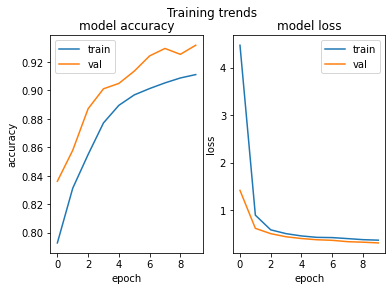

In [ ]:
plot_accuracy_loss(history_1)

#### Inference

Prediction on the validation set

In [ ]:
prediction_info = {
    'batch_size': BATCH_SIZE,
    'verbose': 1
}

Y_pred_1 = predict_data(model=model_1, x=X_val_padded, prediction_info=prediction_info)
Y_pred_1 = np.argmax(Y_pred_1, axis=-1)

Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 2554 samples
40/40 [==============================] - 2s 20ms/step


### 4.1.2 Evaluation

Evaluation focused on the F1 score of the validation prediction

In [ ]:
metric_info_model_1 = evaluate_predictions(predictions=Y_pred_1,
                                   y=Y_val_padded,
                                   eval_val=eval_values)
print('Metrics info: \n{}'.format(metric_info_model_1))

Evaluating predictions! Total samples:  2554
Metrics info: 
{'accuracy': 0.9049581667559659, 'macro_f1': 0.45282121916065565}


## 4.2 Model 2: Bidirectional GRU + FC

Model 2 is composed by:

*   Not trainable embedding layer
*   Bidirectional GRU layer
*   Timedistributed Fully Connected/Dense layer

As it can be noticed there were also inserted:

*    Dropout layers 
*    Regularization parameters

Helpful methods to optimize the training of the model

In [ ]:
def create_model2(tokenizer
                  , embedding_dim
                  , max_seq_length
                  , embedding_matrix
                  , hidden_nodes
                  , output_dim
                  , compile_info):
  """
  Create the Keras model made up of a Bidirectional GRU and a FC layer. 

  :param tokenizer:
  :param embedding_dim:
  :param max_seq_length:
  :param embedding_matrix:
  :param hidden_nodes:
  :param output_dim:
  :param compile_info: dictionary containing compile information

  :return
      model: the built keras sequential model
  """

  model = Sequential()
  model.add(Embedding(input_dim = len(tokenizer.word_index),
                    output_dim = embedding_dim,
                    input_length = max_seq_length,
                    weights = [embedding_matrix],
                    trainable = False,
                    mask_zero = False))
  
  model.add(Dropout(0.7))

  model.add(Bidirectional(GRU(hidden_nodes, 
                              return_sequences=True,
                              kernel_regularizer=tf.keras.regularizers.l2(1e-2),
                              )))
  
  model.add(Dropout(0.7))

  model.add(TimeDistributed(Dense(output_dim, activation='softmax')))

  model.summary()
  model.compile(**compile_info)
  return model

compile_info = {
    'optimizer': tf.keras.optimizers.Nadam(learning_rate=1e-3, 
                                           clipnorm=10),
    'loss': 'categorical_crossentropy',
    'metrics': 'accuracy',
}

model_2 = create_model2(word_tokenizer
                       , embedding_dimension
                       , max_seq_length
                       , V4_embedding_matrix
                       , HIDDEN_NODES
                       , num_classes
                       , compile_info)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 114, 300)          3283800   
                                                                 
 dropout_9 (Dropout)         (None, 114, 300)          0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 114, 256)         330240    
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 114, 256)          0         
                                                                 
 time_distributed_4 (TimeDis  (None, 114, 46)          11822     
 tributed)                                                       
                                                                 
Total params: 3,625,862
Trainable params: 342,062
Non-

### 4.2.1 Training and inference

#### Training

During training process it was monitored only the accuracy score on train and val since since it's not possible to distribute and aggregate F1 scores across batches.

In [ ]:
training_info = {
    'verbose': 1,
    'epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'callbacks': [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=EARLY_STOPPING_PATIENCE,
                                                min_delta=EARLY_STOPPING_MIN_DELTA,
                                                restore_best_weights=True)]
}

history_2, model_2 = train_model(model=model_2, x_train=X_train_padded, y_train=Y_train_cat,
                    x_val=X_val_padded, y_val=Y_val_cat, training_info=training_info)

Start training 
Parameters: {'verbose': 1, 'epochs': 15, 'batch_size': 64, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7fea077b78d0>]}
Epoch 1/15
62/62 [==============================] - 10s 83ms/step - loss: 4.4811 - accuracy: 0.8055 - val_loss: 1.5362 - val_accuracy: 0.8416
Epoch 2/15
62/62 [==============================] - 4s 67ms/step - loss: 0.9716 - accuracy: 0.8433 - val_loss: 0.6518 - val_accuracy: 0.8691
Epoch 3/15
62/62 [==============================] - 4s 66ms/step - loss: 0.5891 - accuracy: 0.8655 - val_loss: 0.5404 - val_accuracy: 0.8788
Epoch 4/15
62/62 [==============================] - 4s 65ms/step - loss: 0.5117 - accuracy: 0.8776 - val_loss: 0.5053 - val_accuracy: 0.8806
Epoch 5/15
62/62 [==============================] - 4s 70ms/step - loss: 0.4872 - accuracy: 0.8829 - val_loss: 0.4873 - val_accuracy: 0.8823
Epoch 6/15
62/62 [==============================] - 4s 68ms/step - loss: 0.4556 - accuracy: 0.8884 - val_loss: 0.4800 - val_accuracy: 0.8833
Epoch

##### Visualization of training tred

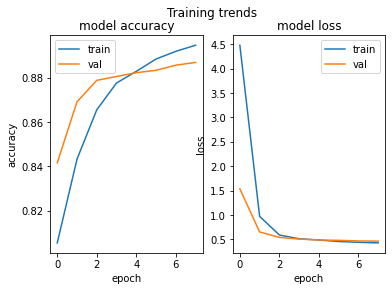

In [ ]:
plot_accuracy_loss(history_2)

#### Inference

Prediction on the validation set

In [ ]:
prediction_info = {
    'batch_size': BATCH_SIZE,
    'verbose': 1
}

Y_pred_2 = predict_data(model=model_2, x=X_val_padded, prediction_info=prediction_info)
Y_pred_2 = np.argmax(Y_pred_2, axis=-1)

Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 2554 samples
40/40 [==============================] - 1s 18ms/step


### 4.2.2 Evaluation

Evaluation focused on the F1 score of the validation prediction

In [ ]:
metric_info_model_2 = evaluate_predictions(predictions=Y_pred_2,
                                   y=Y_val_padded,
                                   eval_val=eval_values)
print('Metrics info: \n{}'.format(metric_info_model_2))

Evaluating predictions! Total samples:  2554
Metrics info: 
{'accuracy': 0.8788209756968772, 'macro_f1': 0.42664913335489313}


## 4.3 Model 3: Bidirectional LSTM + LSTM + FC

Model 3 is composed by:

*   Not trainable embedding layer
*   2 Bidirectional LSTM layers
*   Timedistributed Fully Connected/Dense layer

As it can be noticed there were also inserted:

*    Dropout layers 
*    Regularization parameters

Helpful methods to optimize the training of the model

In [ ]:
def create_model3(tokenizer
                  , embedding_dim
                  , max_seq_length
                  , embedding_matrix
                  , hidden_nodes
                  , output_dim
                  , compile_info):
  """
  Create a Keras model made up of a Bidirectional LSTM, a simple LSTM layer and a FC layer. 

  :param tokenizer:
  :param embedding_dim:
  :param max_seq_length:
  :param embedding_matrix:
  :param hidden_nodes:
  :param output_dim:
  :param compile_info: dictionary containing compile information

  :return
      model: the built keras sequential model
  """
    
  model = Sequential()
  model.add(Embedding(input_dim = len(tokenizer.word_index),
                    output_dim = embedding_dim,
                    input_length = max_seq_length,
                    weights = [embedding_matrix],
                    trainable = False,
                    mask_zero = False))
  
  model.add(Dropout(0.65))

  model.add(Bidirectional(LSTM(hidden_nodes, 
                               return_sequences=True,
                               kernel_regularizer=tf.keras.regularizers.l2(1e-6))))

  model.add(Dropout(0.65))

  model.add(Bidirectional(LSTM(hidden_nodes, 
                              return_sequences=True, 
                              kernel_regularizer=tf.keras.regularizers.l2(1e-6))))

  model.add(Dropout(0.65))

  model.add(TimeDistributed(Dense(output_dim, activation='softmax')))

  model.summary()
  model.compile(**compile_info)
  return model

compile_info = {
    'optimizer': tf.keras.optimizers.Nadam(learning_rate=6e-4
                                           , clipnorm=10.0),
    'loss': 'categorical_crossentropy',
    'metrics': 'accuracy',
}

model_3 = create_model3(word_tokenizer
                       , embedding_dimension
                       , max_seq_length
                       , V4_embedding_matrix
                       , HIDDEN_NODES
                       , num_classes
                       , compile_info)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 114, 300)          3283800   
                                                                 
 dropout_37 (Dropout)        (None, 114, 300)          0         
                                                                 
 bidirectional_29 (Bidirecti  (None, 114, 256)         439296    
 onal)                                                           
                                                                 
 dropout_38 (Dropout)        (None, 114, 256)          0         
                                                                 
 bidirectional_30 (Bidirecti  (None, 114, 256)         394240    
 onal)                                                           
                                                                 
 dropout_39 (Dropout)        (None, 114, 256)        

### 4.3.1 Training and inference

#### Training

During training process it was monitored only the accuracy score on train and val since since it's not possible to distribute and aggregate F1 scores across batches.

In [ ]:
training_info = {
    'verbose': 1,
    'epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'callbacks': [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=EARLY_STOPPING_PATIENCE,
                                                min_delta=EARLY_STOPPING_MIN_DELTA,
                                                restore_best_weights=True)]
}

history_3, model_3 = train_model(model=model_3, x_train=X_train_padded, y_train=Y_train_cat,
                    x_val=X_val_padded, y_val=Y_val_cat, training_info=training_info)

Start training 
Parameters: {'verbose': 1, 'epochs': 15, 'batch_size': 64, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7fe94bf55690>]}
Epoch 1/15
62/62 [==============================] - 20s 165ms/step - loss: 1.0761 - accuracy: 0.7948 - val_loss: 0.6173 - val_accuracy: 0.8322
Epoch 2/15
62/62 [==============================] - 8s 132ms/step - loss: 0.6111 - accuracy: 0.8284 - val_loss: 0.5481 - val_accuracy: 0.8624
Epoch 3/15
62/62 [==============================] - 8s 132ms/step - loss: 0.5260 - accuracy: 0.8576 - val_loss: 0.4627 - val_accuracy: 0.8740
Epoch 4/15
62/62 [==============================] - 8s 132ms/step - loss: 0.4554 - accuracy: 0.8749 - val_loss: 0.4198 - val_accuracy: 0.8831
Epoch 5/15
62/62 [==============================] - 8s 132ms/step - loss: 0.4136 - accuracy: 0.8841 - val_loss: 0.4064 - val_accuracy: 0.8871
Epoch 6/15
62/62 [==============================] - 8s 133ms/step - loss: 0.3859 - accuracy: 0.8910 - val_loss: 0.4016 - val_accuracy: 0.8885

##### Visualization of training trend

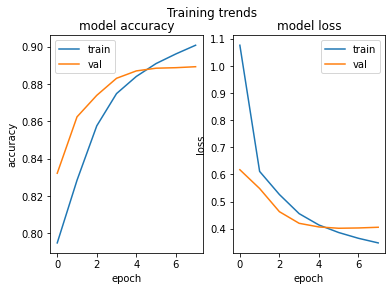

In [ ]:
plot_accuracy_loss(history_3)

#### Inference

Prediction on validation set

In [ ]:
prediction_info = {
    'batch_size': BATCH_SIZE,
    'verbose': 1
}

Y_pred_3 = predict_data(model=model_3, x=X_val_padded, prediction_info=prediction_info)
Y_pred_3 = np.argmax(Y_pred_3, axis=-1)

Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 2554 samples
40/40 [==============================] - 4s 38ms/step


### 4.3.2 Evaluation

Evaluation focused on the F1 score of the validation prediction

In [ ]:
metric_info_model_3 = evaluate_predictions(predictions=Y_pred_3,
                                   y=Y_val_padded,
                                   eval_val=eval_values)
print('Metrics info: \n{}'.format(metric_info_model_3))

Evaluating predictions! Total samples:  2554
Metrics info: 
{'accuracy': 0.8739782109934193, 'macro_f1': 0.5151921840316643}


## 4.4 Model 4: Bidirectional LSTM + FC + FC

Model 4 is composed by:

*   Not trainable embedding layer
*   Bidirectional LSTM layer
*   2 Timedistributed Fully Connected/Dense layer

As it can be noticed there were also inserted:

*    Dropout layers 
*    Regularization parameters

Helpful methods to optimize the training of the model

In [ ]:
def create_model4(tokenizer
                  , embedding_dim
                  , max_seq_length
                  , embedding_matrix
                  , hidden_nodes
                  , output_dim
                  , compile_info):
  """
  Create a Keras model made up of a Bidirectional LSTM and two FC layer. 

  :param tokenizer:
  :param embedding_dim:
  :param max_seq_length:
  :param embedding_matrix:
  :param hidden_nodes:
  :param output_dim:
  :param compile_info: dictionary containing compile information

  :return
      model: the built keras sequential model
  """

  model = Sequential()
  model.add(Embedding(input_dim = len(tokenizer.word_index),
                    output_dim = embedding_dim,
                    input_length = max_seq_length,
                    weights = [embedding_matrix],
                    trainable = False,
                    mask_zero = False))

  model.add(Dropout(0.75,seed=13))

  model.add(Bidirectional(LSTM(hidden_nodes, 
                               return_sequences=True,
                               kernel_regularizer=tf.keras.regularizers.l2(5e-4),
                               )))
  
  model.add(Dropout(0.75,seed=13))

  model.add(Dense(int(hidden_nodes/2), 
                  activation='leaky_relu', 
                  kernel_regularizer=tf.keras.regularizers.l2(5e-4)))

  model.add(Dropout(0.75,seed=13))

  model.add(TimeDistributed(Dense(output_dim, activation='softmax')))


  model.summary()
  model.compile(**compile_info)
  return model

compile_info = {
    'optimizer': tf.keras.optimizers.Nadam(learning_rate=3e-3,clipnorm =10.0),
    # 'optimizer': 'adam',
    'loss': 'categorical_crossentropy',
    'metrics': 'accuracy',
}

model_4 = create_model4(word_tokenizer
                       , embedding_dimension
                       , max_seq_length
                       , V4_embedding_matrix
                       , HIDDEN_NODES
                       , num_classes
                       , compile_info)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 114, 300)          3283800   
                                                                 
 dropout_13 (Dropout)        (None, 114, 300)          0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 114, 256)         439296    
 nal)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 114, 256)          0         
                                                                 
 dense_7 (Dense)             (None, 114, 64)           16448     
                                                                 
 dropout_15 (Dropout)        (None, 114, 64)           0         
                                                      

### 4.4.1 Training and inference

#### Training

During training process it was monitored only the accuracy score on train and val since since it's not possible to distribute and aggregate F1 scores across batches.

In [ ]:
training_info = {
    'verbose': 1,
    'epochs': NUM_EPOCHS ,
    'batch_size': BATCH_SIZE,
    'callbacks': [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                patience = EARLY_STOPPING_PATIENCE,
                                                min_delta = EARLY_STOPPING_MIN_DELTA,
                                                restore_best_weights=True)]
}

history_4, model_4 = train_model(model=model_4, x_train=X_train_padded, y_train=Y_train_cat,
                    x_val=X_val_padded, y_val=Y_val_cat, training_info=training_info)

Start training 
Parameters: {'verbose': 1, 'epochs': 15, 'batch_size': 64, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7fe94f7d9e10>]}
Epoch 1/15
62/62 [==============================] - 12s 93ms/step - loss: 1.1497 - accuracy: 0.7844 - val_loss: 0.6734 - val_accuracy: 0.8541
Epoch 2/15
62/62 [==============================] - 4s 71ms/step - loss: 0.6429 - accuracy: 0.8448 - val_loss: 0.5463 - val_accuracy: 0.8730
Epoch 3/15
62/62 [==============================] - 4s 71ms/step - loss: 0.5638 - accuracy: 0.8617 - val_loss: 0.5034 - val_accuracy: 0.8757
Epoch 4/15
62/62 [==============================] - 4s 72ms/step - loss: 0.5285 - accuracy: 0.8679 - val_loss: 0.4852 - val_accuracy: 0.8793
Epoch 5/15
62/62 [==============================] - 4s 72ms/step - loss: 0.8841 - accuracy: 0.8379 - val_loss: 0.5390 - val_accuracy: 0.8796
Epoch 6/15
62/62 [==============================] - 4s 71ms/step - loss: 0.5527 - accuracy: 0.8689 - val_loss: 0.5043 - val_accuracy: 0.8805
Epoch

##### Visualization of training trend

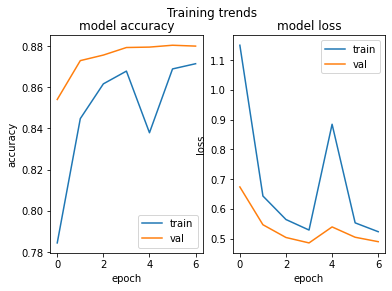

In [ ]:
plot_accuracy_loss(history_4)

#### Inference

Prediction on the validation set

In [ ]:
prediction_info = {
    'batch_size': BATCH_SIZE,
    'verbose': 1
}

Y_pred_4 = predict_data(model=model_4, x=X_val_padded, prediction_info=prediction_info)
Y_pred_4 = np.argmax(Y_pred_4, axis=-1)

Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 2554 samples
40/40 [==============================] - 2s 18ms/step


### 4.4.2 Evaluation

Evaluation focused on the F1 score of the validation prediction

In [ ]:
metric_info_model_4 = evaluate_predictions(predictions=Y_pred_4,
                                   y=Y_val_padded,
                                   eval_val=eval_values)
print('Metrics info: \n{}'.format(metric_info_model_4))

Evaluating predictions! Total samples:  2554
Metrics info: 
{'accuracy': 0.8729821813735592, 'macro_f1': 0.56323604600345}


# 5. Discussions

In [ ]:
metric_info = [metric_info_model_1, metric_info_model_2, metric_info_model_3, metric_info_model_4]

In [ ]:
for idx, info in enumerate(metric_info):
  print(f"[SUMMARY] Model_{idx+1} ---- accuracy: {info['accuracy']}, macro_f1: {info['macro_f1']}")

[SUMMARY] Model_1 ---- accuracy: 0.8745208754069983, macro_f1: 0.5164202195516286
[SUMMARY] Model_2 ---- accuracy: 0.8788209756968772, macro_f1: 0.42664913335489313
[SUMMARY] Model_3 ---- accuracy: 0.8739782109934193, macro_f1: 0.5151921840316643
[SUMMARY] Model_4 ---- accuracy: 0.8729821813735592, macro_f1: 0.56323604600345


We can see from the results that the best scores are obtained by the fourth model and the first one on the validation set.
Now evaluation it will be done on prediction of the two best models on the test set and look for any interesting results.

Baseline model prediction on test set

In [ ]:
prediction_info = {
    'batch_size': BATCH_SIZE,
    'verbose': 1
}

Y_pred_final = predict_data(model=model_1, x=X_test_padded, prediction_info=prediction_info)
Y_pred_final = np.argmax(Y_pred_final, axis=-1)

metric_info_model_final = evaluate_predictions(predictions=Y_pred_final,
                                   y=Y_test_padded,
                                   eval_val=eval_values)
print('Metrics info: \n{}'.format(metric_info_model_final))

Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 1276 samples
20/20 [==============================] - 0s 21ms/step
Evaluating predictions! Total samples:  1276
Metrics info: 
{'accuracy': 0.8817164384315019, 'macro_f1': 0.5454179409111058}


Model 4 prediction on test set

In [ ]:
prediction_info = {
    'batch_size': BATCH_SIZE,
    'verbose': 1
}

Y_pred_final_2 = predict_data(model=model_4, x=X_test_padded, prediction_info=prediction_info)
Y_pred_final_2 = np.argmax(Y_pred_final_2, axis=-1)

metric_info_model_final = evaluate_predictions(predictions=Y_pred_final_2,
                                   y=Y_test_padded,
                                   eval_val=eval_values)
print('Metrics info: \n{}'.format(metric_info_model_final))

Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 1276 samples
20/20 [==============================] - 0s 24ms/step
Evaluating predictions! Total samples:  1276
Metrics info: 
{'accuracy': 0.8786503877247979, 'macro_f1': 0.5871029139233358}


Let's see some errors made by the baseline model

In [ ]:
def visual_mistakes(x, predictions, y, num_sen, word_tokenizer, tag_tokenizer):
  print('[Debug] Misrecognized labels:')
  print(f'Sentence: {word_tokenizer.sequences_to_texts(x)[num_sen]}')
  for idx, (pred, lab) in enumerate(zip(predictions[num_sen], y[num_sen])):
    if pred != lab:
      print(f'Real: {tag_tokenizer.index_word[lab]} \tPredicted: {tag_tokenizer.index_word[pred]} \tin position {idx+1}')

visual_mistakes(X_test_padded, Y_pred_final, Y_test_padded, 5, word_tokenizer, tag_tokenizer)

[Debug] Misrecognized labels:
Sentence: `` there is no business reason for my departure , '' nor any disagreement over policy , he added .
Real: `` 	Predicted: , 	in position 1
Real: ex 	Predicted: nnp 	in position 2
Real: vbz 	Predicted: in 	in position 3
Real: dt 	Predicted: nnp 	in position 4
Real: nn 	Predicted: nnp 	in position 5
Real: prp$ 	Predicted: nn 	in position 8
Real: '' 	Predicted: , 	in position 11
Real: cc 	Predicted: nnp 	in position 12
Real: dt 	Predicted: in 	in position 13
Real: nn 	Predicted: nnp 	in position 14
Real: prp 	Predicted: nn 	in position 18
Real: vbd 	Predicted: nn 	in position 19


Let's see some errors made by the fourth model

In [ ]:
visual_mistakes(X_test_padded, Y_pred_final_2, Y_test_padded, 5, word_tokenizer, tag_tokenizer)

[Debug] Misrecognized labels:
Sentence: `` there is no business reason for my departure , '' nor any disagreement over policy , he added .
Real: `` 	Predicted: '' 	in position 1
Real: ex 	Predicted: in 	in position 2
Real: vbz 	Predicted: in 	in position 3
Real: dt 	Predicted: nn 	in position 4
Real: prp$ 	Predicted: nn 	in position 8
Real: cc 	Predicted: nn 	in position 12
Real: dt 	Predicted: nn 	in position 13
Real: in 	Predicted: nn 	in position 15
Real: prp 	Predicted: nn 	in position 18
Real: vbd 	Predicted: nn 	in position 19


## 5.1 Suggestions in order to improve the work done in this assignment:

*    Refine and improve the tuning process on the models in order to find the best configuration and hyperparameter values.
*    Enrich the dataset with more sentences, in paticular trying to cover those tags bad predicted.
*    An unbalanced dataset could be the motivation behind a low f1-score, a possibile solution could be represented by assigning higher weights to classes that have less classes available. This has been tried here below:

In [ ]:
from collections import Counter

In [ ]:
def compute_class_weights(Y_train, Y_val, Y_test, num_classes):
  Y_encoded = flatten(Y_train + Y_val + Y_test)
  counter = Counter(Y_encoded)

  class_weights = {}
  for key, count in counter.items():
    class_weights[key] = 10**1 / count

  class_weights[0] = class_weights[1] * 10**(-1)
  return class_weights

def compute_sample_weights(Y, class_weights):
  sample_weights = np.zeros((Y.shape))
  for r, sublist in enumerate(Y):
    for c, item in enumerate(sublist):
      sample_weights[r, c] = class_weights[item]

  return sample_weights

In [ ]:
class_weights = compute_class_weights(Y_train_encoded, Y_val_encoded, Y_test_encoded, num_classes)
sample_weigths_train = compute_sample_weights(Y_train_padded, class_weights)
sample_weigths_val = compute_sample_weights(Y_val_padded, class_weights)

In [ ]:
model_1_weighted = create_model1(word_tokenizer
                       , embedding_dimension
                       , max_seq_length
                       , V4_embedding_matrix
                       , HIDDEN_NODES
                       , num_classes
                       , compile_info)

training_info = {
    'verbose': 1,
    'epochs': 20,
    'batch_size': BATCH_SIZE,
    'callbacks': [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience= EARLY_STOPPING_PATIENCE,
                                                min_delta = EARLY_STOPPING_MIN_DELTA,
                                                restore_best_weights=True)],
    'sample_weight': sample_weigths_train
}

history_1_weighted = model_1_weighted.fit(x=X_train_padded, y=Y_train_cat,
                                          verbose=1,
                                          epochs=20,
                                          batch_size=64,
                                          callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=EARLY_STOPPING_PATIENCE,
                                                min_delta = EARLY_STOPPING_MIN_DELTA,
                                                restore_best_weights=True),
                                          sample_weight=sample_weigths_train,
                                          validation_data=(X_val_padded, Y_val_cat, sample_weigths_val))

# history_1_weighted, model_1_weighted = train_model(model=model_1_weighted, x_train=X_train_padded, y_train=Y_train_cat,
#                     x_val=X_val_padded, y_val=Y_val_cat, training_info=training_info)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 114, 300)          3283800   
                                                                 
 dropout_40 (Dropout)        (None, 114, 300)          0         
                                                                 
 bidirectional_31 (Bidirecti  (None, 114, 256)         439296    
 onal)                                                           
                                                                 
 dropout_41 (Dropout)        (None, 114, 256)          0         
                                                                 
 time_distributed_18 (TimeDi  (None, 114, 46)          11822     
 stributed)                                                      
                                                                 
Total params: 3,734,918
Trainable params: 451,118
Non